<a href="https://colab.research.google.com/github/Sonukumari97/Diasater-Tweet-With-BERT_Model/blob/main/Diasaster_Tweet_NLP_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install text_hammer 

     |████████████████████████████████| 115 kB 4.3 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 4.2 MB/s 
     |████████████████████████████████| 636 kB 41.1 MB/s 
     |████████████████████████████████| 895 kB 42.8 MB/s 
     |████████████████████████████████| 3.3 MB 39.5 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Importing Libraries

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pathlib 
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix
% matplotlib inline
sns.set()
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
import text_hammer as th

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sonukumari47","key":"54f279af05020cde7a218048dcd94587"}'}

#Setting kaggle environment

In [ ]:
# setting environment for kaggle 
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

#Download DataSet

In [ ]:
!kaggle competitions download -c nlp-getting-started

  0% 0.00/22.2k [00:00<?, ?B/s]
100% 22.2k/22.2k [00:00<00:00, 40.6MB/s]
  0% 0.00/411k [00:00<?, ?B/s]
100% 411k/411k [00:00<00:00, 57.5MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 62.3MB/s]


#Data Reading

In [ ]:
df1 = pd.read_csv("train.csv")
df1.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df2 = pd.read_csv("test.csv")
df2.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
print(f"Shape of train DataSet {df1.shape}")
print(f"Shape of test DataSet {df2.shape}")

Shape of train DataSet (7613, 5)
Shape of test DataSet (3263, 4)


In [ ]:
print(f"Null Value in Train Dataset \n {df1.isna().sum()} ")
print("\n")
print(f"Null Value in Test Dataset \n {df2.isna().sum()} ")

Null Value in Train Dataset 
 id             0
keyword       61
location    2533
text           0
target         0
dtype: int64 


Null Value in Test Dataset 
 id             0
keyword       26
location    1105
text           0
dtype: int64 


In [ ]:
# # If there is some duplicates persent in data then remove that to make text more clear
# print(len(df1))
# df1 = df1.drop_duplicates('text', keep='last')
# print(len(df1))

#Data Visualization

0    4342
1    3271
Name: target, dtype: int64


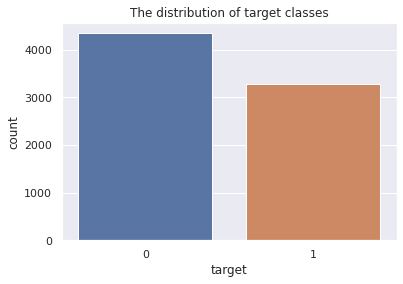

In [ ]:
print(df1['target'].value_counts())
sns.countplot(df1['target'])
plt.title("The distribution of target classes");

Unique keywords num=222
Unique keywords num=222


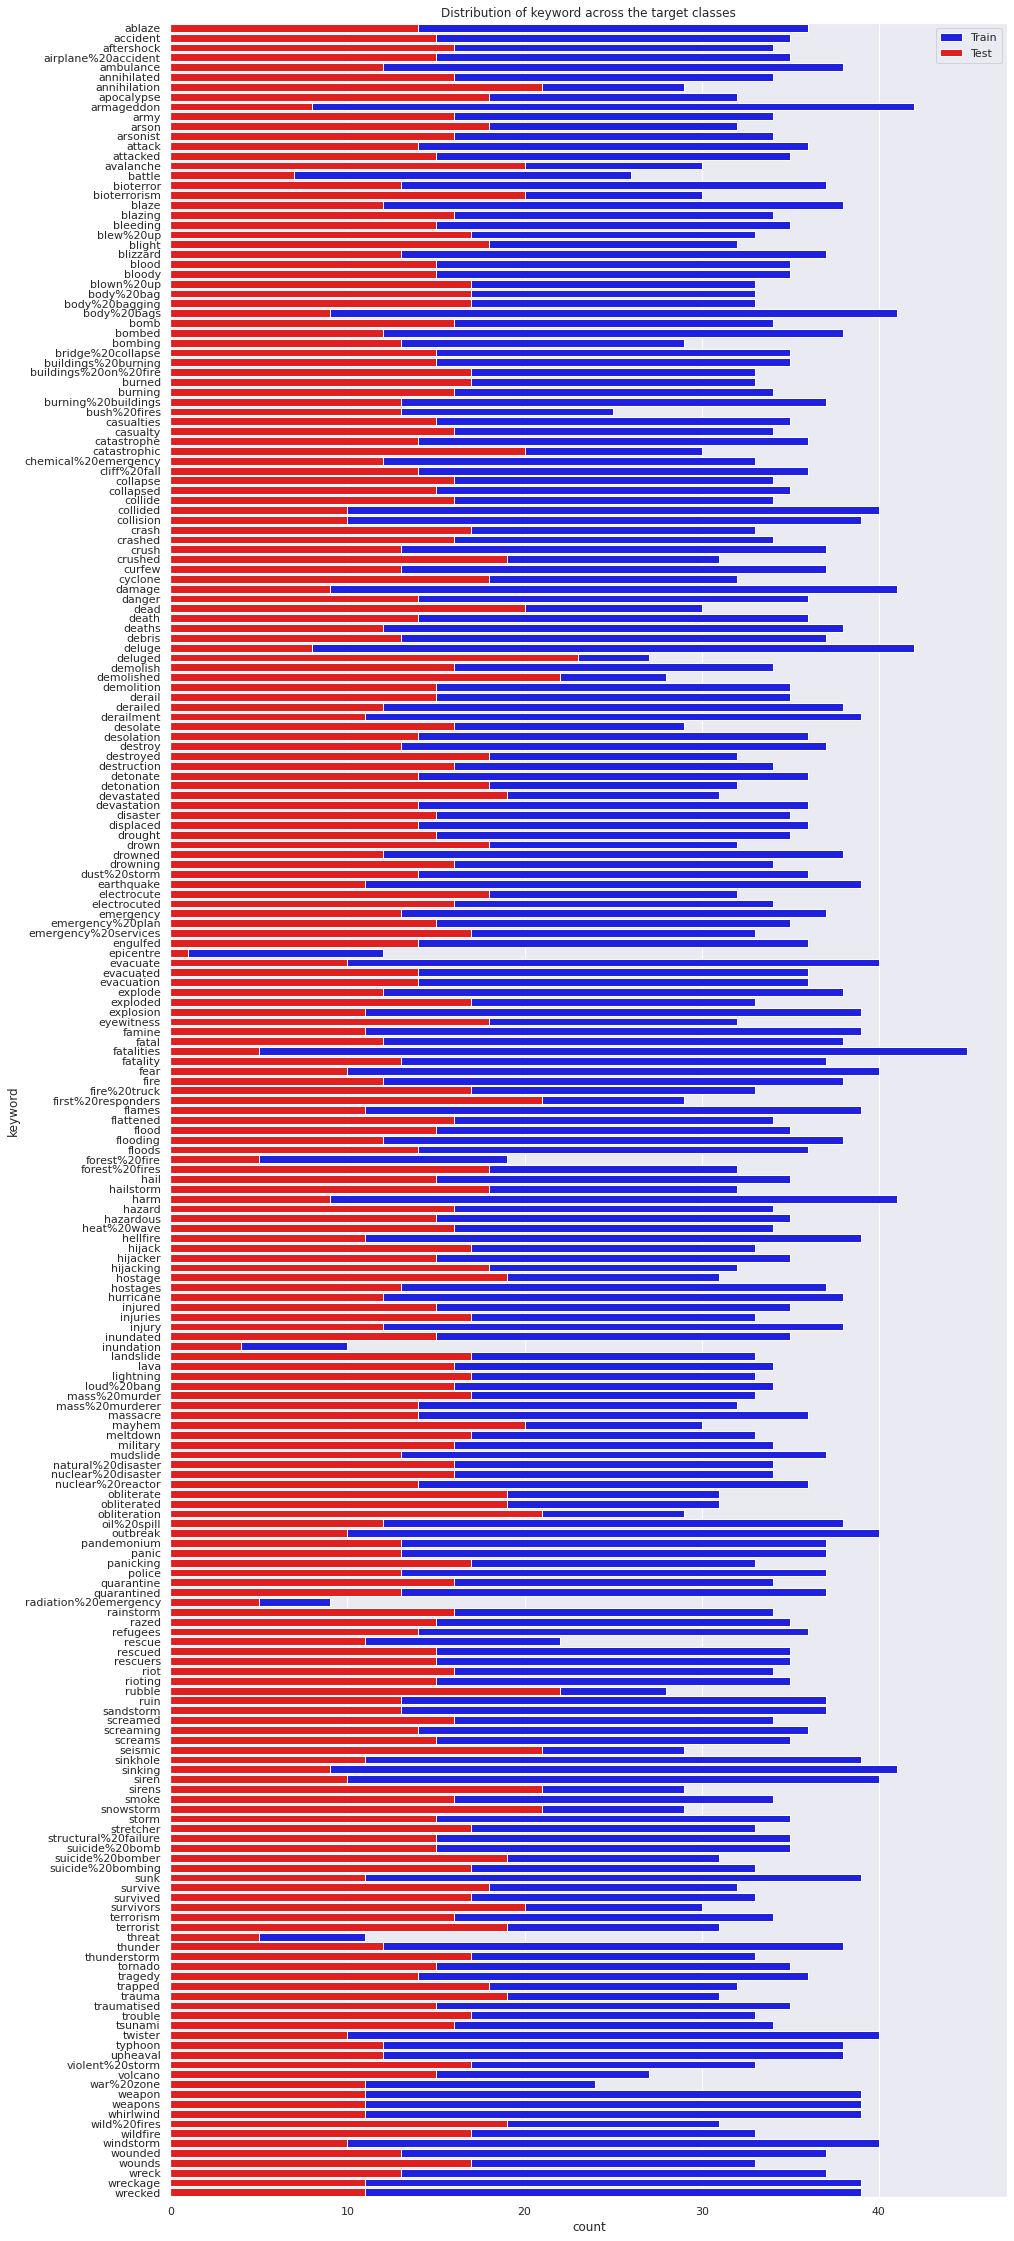

In [ ]:
plt.figure(figsize=(15,40))
print(f'Unique keywords num={len(df1.keyword.unique())}')
print(f'Unique keywords num={len(df2.keyword.unique())}')
sns.countplot(y = df1['keyword'], color=(0,0,1), label='Train')
sns.countplot(y = df2['keyword'], color=(1,0,0), label='Test')
plt.legend()
plt.title("Distribution of keyword across the target classes");

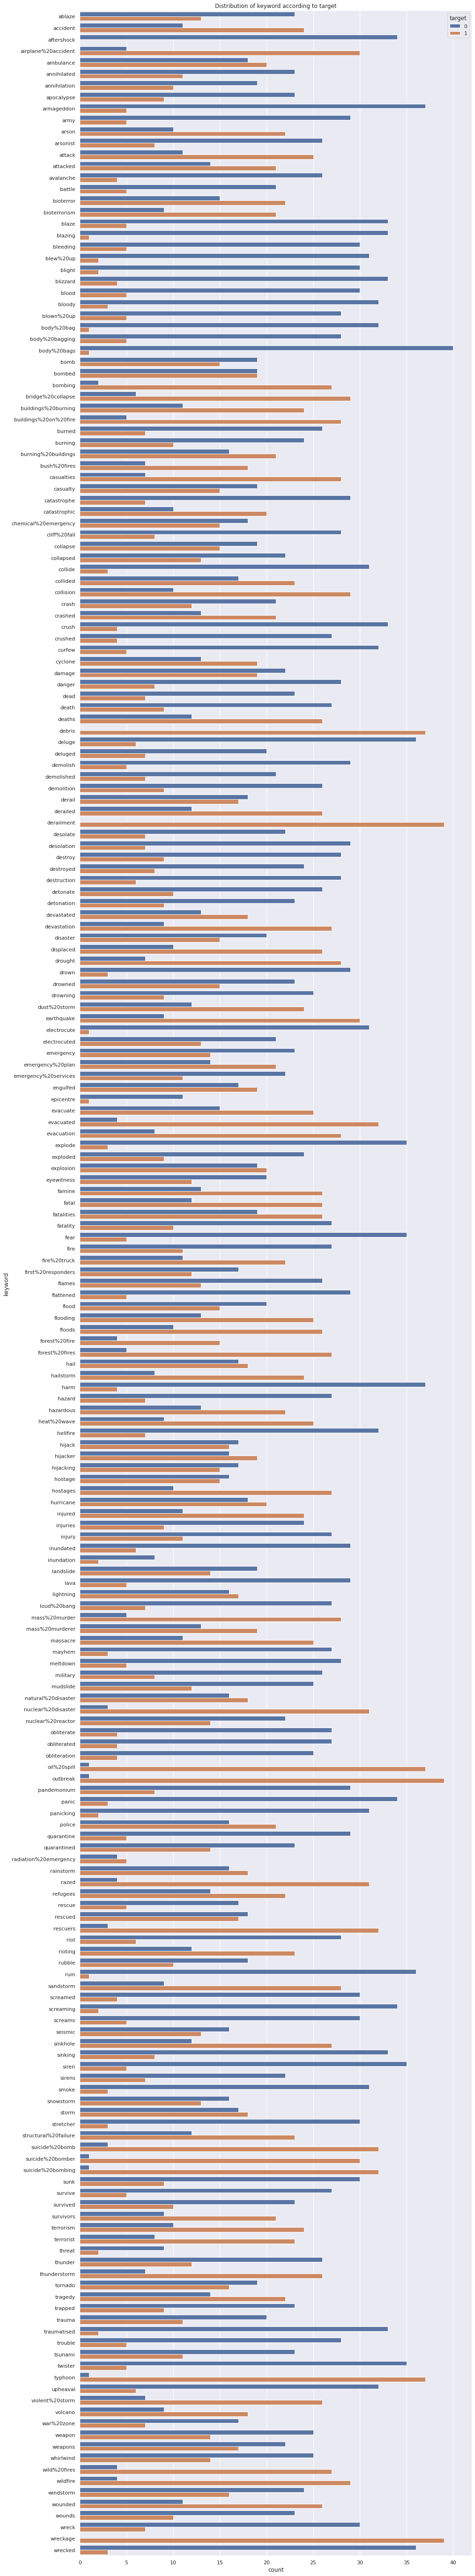

In [ ]:
plt.figure(figsize = (15,100))
sns.countplot(data = df1, y = 'keyword', hue = 'target')
plt.title("Distribution of keyword according to target");

#Text Pre-Processing
some signs and characters need to be removed , again cleaning the text data before training is a good practice. 

We use bert which is more advanced architecture (**state of art model**) , it doesn't much affect if we dont do data cleaning , bert dont need extensive text_cleaning because bert comes with 40/60000 words hence its really not necessary to do text_cleaning but removing the special characters are good practice.

In [ ]:
from tqdm._tqdm_notebook import tqdm_notebook # for nice looking progress part 
tqdm_notebook.pandas() # enable progress_apply method 
# for seeing progress we use progress_apply just using apply doesn't show any progress

def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))

    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

In [ ]:
# getting most frequently comming latter 

# IN TRAIN DATASET 
df1_key = df1["keyword"].value_counts().index[0]
df1_loc = df1["location"].value_counts().index[0]
print(f"most frequently comming keyword in train data is :  '{df1_key}' ")
print(f"most frequently comming location in train data is:   '{df1_loc}' ")

# IN TEST DATASET 
df2_key = df2["keyword"].value_counts().index[0]
df2_loc = df2["location"].value_counts().index[0]
print(f"most frequently comming keyword in test data is :  '{df2_key}' ")
print(f"most frequently comming location in test data is :  '{df2_loc}' ")

most frequently comming keyword in train data is :  'fatalities' 
most frequently comming location in train data is:   'USA' 
most frequently comming keyword in test data is :  'deluged' 
most frequently comming location in test data is :  'New York' 


In [ ]:
# Filling Missing Values by Most Frequent Value 

# IN TRAIN DATASET
df1['keyword'] = df1['keyword'].fillna(df1['keyword'].value_counts().idxmax())
df1['location'] = df1['location'].fillna(df1['location'].value_counts().idxmax())

# IN TEST DATASET 
df2['keyword'] = df2['keyword'].fillna(df2['keyword'].value_counts().idxmax())
df2['location'] = df2['location'].fillna(df2['location'].value_counts().idxmax())

In [ ]:
# Adding Keyword and Text because both are important for our prediction 

# IN TRAIN DATASET
df1["sentence"] = df1['keyword'] + " " + df1['text']
train_text = np.array(df1["sentence"])
y = np.array(df1['target'])
print(train_text[0])
print(f" target type : '{type(y)}' ")
print(f" train_text type : '{type(train_text)}' ")

# IN TEST DATASET 
df2["sentence"] = df2['keyword'] + " " + df2['text']
test_text = np.array(df2["sentence"])
print(test_text[0])

fatalities Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
 target type : '<class 'numpy.ndarray'>' 
 train_text type : '<class 'numpy.ndarray'>' 
deluged Just happened a terrible car crash


In [ ]:
df1.head()

,id,keyword,location,text,target,sentence
0,1,fatalities,USA,Our Deeds are the Reason of this #earthquake M...,1,fatalities Our Deeds are the Reason of this #e...
1,4,fatalities,USA,Forest fire near La Ronge Sask. Canada,1,fatalities Forest fire near La Ronge Sask. Canada
2,5,fatalities,USA,All residents asked to 'shelter in place' are ...,1,fatalities All residents asked to 'shelter in ...
3,6,fatalities,USA,"13,000 people receive #wildfires evacuation or...",1,"fatalities 13,000 people receive #wildfires ev..."
4,7,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...,1,fatalities Just got sent this photo from Ruby ...


In [ ]:
train_cleaned_df = text_preprocessing(df1,'sentence')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

In [ ]:
train_cleaned_df[train_cleaned_df.target == 0]

,id,keyword,location,text,target,sentence
15,23,fatalities,USA,What's up man?,0,fatalities whats up man
16,24,fatalities,USA,I love fruits,0,fatalities i love fruits
17,25,fatalities,USA,Summer is lovely,0,fatalities summer is lovely
18,26,fatalities,USA,My car is so fast,0,fatalities my car is so fast
19,28,fatalities,USA,What a goooooooaaaaaal!!!!!!,0,fatalities what a goooooooaaaaaal
...,...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0,wrecked engineshed great atmosphere at the bri...
7582,10834,wrecked,USA,Cramer: Iger's 3 words that wrecked Disney's s...,0,wrecked cramer igers 3 words that wrecked disn...
7584,10837,fatalities,USA,These boxes are ready to explode! Exploding Ki...,0,fatalities these boxes are ready to explode ex...
7587,10841,fatalities,USA,Sirens everywhere!,0,fatalities sirens everywhere


In [ ]:
# Creating a copy 
train_df = train_cleaned_df.copy()

#Pretrained BERT(Bidirectional Encoder Representations from Transformers) Model

In [ ]:
from transformers import AutoTokenizer,TFBertModel # tensorflow bert model 
# to take max acc we use large bert model and uncased means lower case model

# tokenizer used here for converting text data into bert input form 
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')

# Using pre_trained bert model 
bert = TFBertModel.from_pretrained('bert-large-uncased') 

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Taking Some Example and see the difference
tokenizer('this is me nlp notebook and i am implementing some bert model &*&*&&')

{'input_ids': [101, 2023, 2003, 2033, 17953, 2361, 14960, 1998, 1045, 2572, 14972, 2070, 14324, 2944, 1004, 1008, 1004, 1008, 1004, 1004, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

**For training bert model we need input_ids , token_type_ids and attention_mask which was given by tokenizer as a dictionary.**

**input_ids :** useful for train the bert model

**token_type_ids :** all value almost similiar so need to take this to train bert model

**attention_mask :** here also all value are same so no need to train bert model using these but if we used then this will not affect that much.

#Convert Our text data into BERT input format

In [ ]:
# Checking max len of our text data according to this take max_len 
print("max len of tweets",max([len(x.split()) for x in train_text]))
max_length = 36

max len of tweets 32


In [ ]:
x_train = tokenizer(text = train_text.tolist(), # text data in list format 
                    add_special_tokens = True, # taking special token 
                    max_length = 36, 
                    truncation = True, # if any text have more than max_len = 36 then this will truncated that extra words
                    padding = True, # if text has less word than max_len then this add padding to make it equal to max_len
                    return_tensors = 'tf', # we use tensorflow format of bert model so use tf as tensor 
                    return_token_type_ids = False, # not that useful so ignore 
                    return_attention_mask = True, # True and False doesn't effect that much
                    verbose = True) # containing more words than necessary tell everything that model done

In [ ]:
x_train['input_ids'].shape # (parameter, no of dimension)

TensorShape([7613, 36])

In [ ]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

In [ ]:
# Target
y_train = df1.target.values
y_train

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

**here we see there is small difference in 0 and 1 target so there is no problem of data in-balance**

#Model Architecture

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [ ]:
max_len = 36 

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense

# creating input_ids as one input layer and another input_mask as second layer as we pass two input in bert model

#----- like input_ids and attention_mask 
#----- if we use token_type_ids also then we have to create 3 input layer for our model to train on bert model
#---- shape = (dimension as max_len , ) no need to define no of training example we give to our model like here 7503
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Embedding
#---> bert model output is : (last_hidden_layer , pooler_output)
#---> last_hidden_layer.shape = (None, max_len, 1024)
#---> pooler_output.shape = (None, 1024)
#-------> both used for classification but if we use last_hidden_layer then we have to specify the GlobalMaxPool1D
#-------> pooler_output doesn't need any pooling because this doesn't have any max_len parameter
embeddings = bert(input_ids,attention_mask = input_mask)[1] #(0 is the last hidden states,1 means pooler_output)


out = tf.keras.layers.Dropout(0.1)(embeddings) # Dropout to remove overfitting
out = Dense(128, activation='relu')(out) # Hidden layer
out = tf.keras.layers.Dropout(0.1)(out) # another Dropout layer
out = Dense(32,activation = 'relu')(out) # another hidden layer

y = Dense(1,activation = 'sigmoid')(out) # last hidden layer or we can say last layer(output layer)
    
# ***************** CREATING MODEL *************************** # 
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

# ************* MODEL READING ***************#
#---> [input_ids, input_mask, embedding]
# so here embedding which use bert model is 3 layer at index 2 so use this layer for training 
# use again bert model layer to make mask prediction 
model.layers[2].trainable = True
# for training bert our lr must be so small

In [ ]:
# model architecture
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 36)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 36)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_153 (Dropout)           (None, 1024)         0           tf_bert_model_1[0][1]      

In [ ]:
optimizer = Adam(learning_rate = 6e-06, # this learning rate is for bert model , taken from huggingface website 
                 epsilon = 1e-08, # take small value of epsilon we 1/0 condition doesn't make
                 decay = 0.01,
                 clipnorm = 1.0)

# Set loss and metrics
metric = BinaryAccuracy('accuracy'),

# Compile the model
model.compile(optimizer = optimizer,
              loss = BinaryCrossentropy(from_logits = True), 
              metrics = metric)

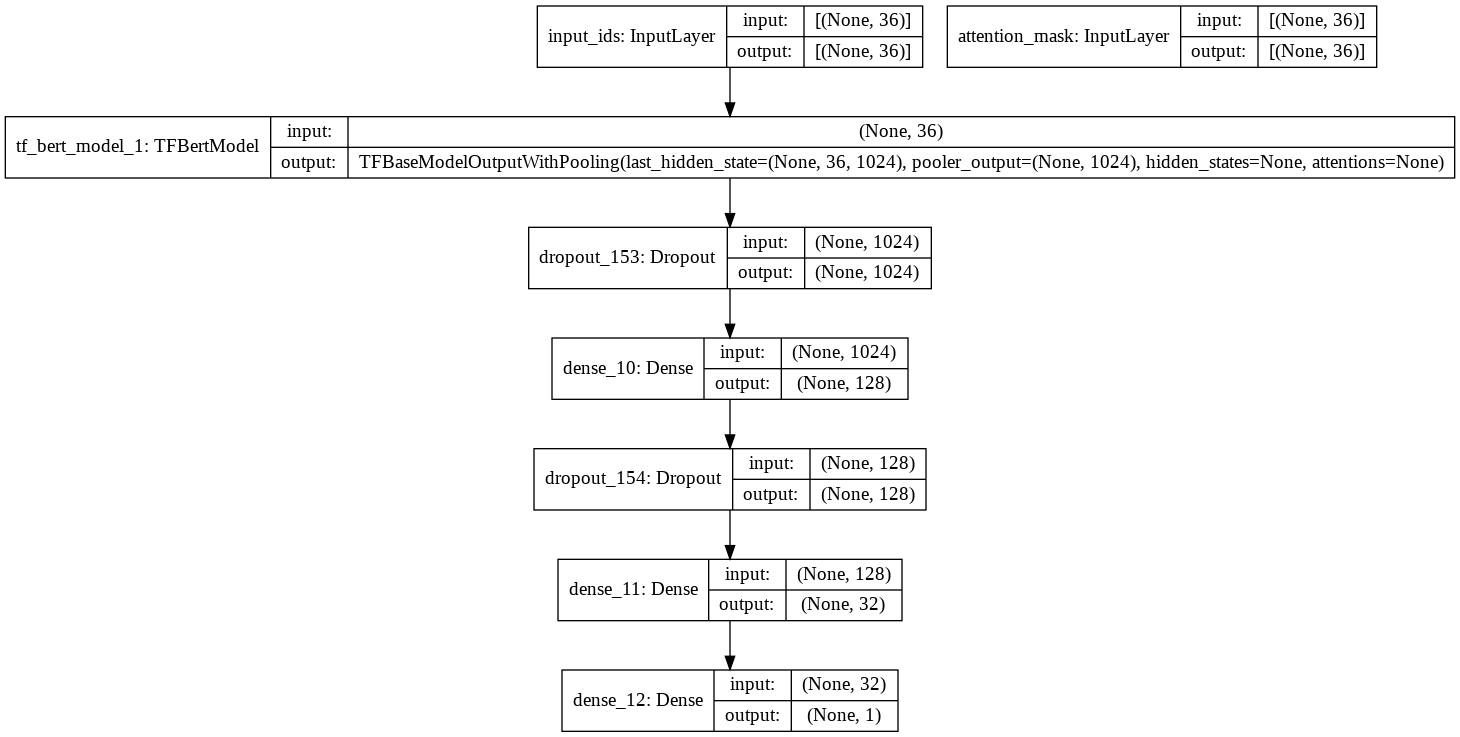

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
train_history = model.fit(x = {'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']},
                          y = y_train,
                          validation_split = 0.1,
                          epochs = 10,
                          batch_size = 10
                          )

Epoch 1/10
686/686 [==============================] - 582s 768ms/step - loss: 0.5354 - accuracy: 0.7424 - val_loss: 0.4167 - val_accuracy: 0.8360
Epoch 2/10
686/686 [==============================] - 516s 753ms/step - loss: 0.4181 - accuracy: 0.8332 - val_loss: 0.4044 - val_accuracy: 0.8412
Epoch 3/10
686/686 [==============================] - 517s 754ms/step - loss: 0.3975 - accuracy: 0.8459 - val_loss: 0.4154 - val_accuracy: 0.8346
Epoch 4/10
686/686 [==============================] - 519s 756ms/step - loss: 0.3800 - accuracy: 0.8516 - val_loss: 0.4316 - val_accuracy: 0.8215
Epoch 5/10
686/686 [==============================] - 519s 756ms/step - loss: 0.3726 - accuracy: 0.8540 - val_loss: 0.4144 - val_accuracy: 0.8373
Epoch 6/10
686/686 [==============================] - 516s 753ms/step - loss: 0.3645 - accuracy: 0.8608 - val_loss: 0.4230 - val_accuracy: 0.8333
Epoch 7/10
686/686 [==============================] - 517s 754ms/step - loss: 0.3566 - accuracy: 0.8631 - val_loss: 0.4222 -

#Prediction on test Dataset

In [ ]:
x_test = tokenizer(text = test_text.tolist(),
                   add_special_tokens=True,
                   max_length=36,
                   truncation=True,
                   padding=True, 
                   return_tensors='tf',
                   return_token_type_ids = False,
                   return_attention_mask = True,
                   verbose = True)

In [ ]:
predicted = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [ ]:
# seeting threshold to get value in our label specified
y_predicted = np.where(predicted>0.5,1,0)

Text(0.5, 1.0, 'Training-Validation Accuracy')

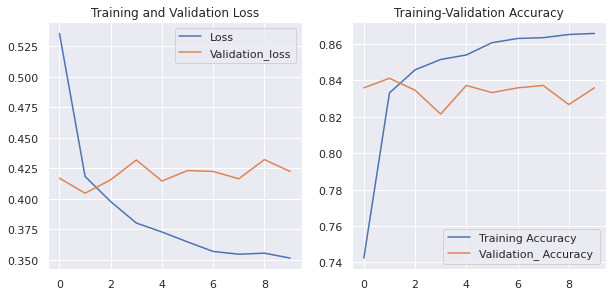

In [ ]:
#saving the model history
loss = pd.DataFrame(train_history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

In [ ]:
y_predicted.shape

(3263, 1)

In [ ]:
y_predicted = y_predicted.reshape((1,3263))[0]

In [ ]:
y_predicted.shape

(3263,)

#Save Result into CSV File

In [ ]:
# Getting same id as Sample_submission given to us
sample_df = pd.read_csv('sample_submission.csv')
sample_df['id'] = df2.id
sample_df['target'] = y_predicted

In [ ]:
sample_df.to_csv('my_submission.csv',index = False)